<a href="https://colab.research.google.com/github/urwa-fatima/AdvanceMachineLearning_GNN/blob/main/GNN_AML_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESIGNING GRAPH NEURAL NETWORK (GNN)

Name: Urwa Fatima

## 1. Introduction
Graphs are powerful data structures that represent networks of entities and their relationships. While traditional neural networks excel at analyzing structured data such as images or text, they face limitations when dealing with complex, interconnected data, such as biological structures or social networks. Graph Neural Networks (GNNs) are designed to overcome these limitations, enabling the extraction of valuable insights from data best represented as graphs.



### 1.1 Limitations of Traditional Neural Networks
Elaborating on the limitations of traditional neural networks when dealing with graph-structured data


* **Variable-Sized Inputs**: Traditional neural networks, such as feedforward and convolutional networks, require fixed-size inputs. For example, CNNs expect images of a specific dimension, making it difficult to process graphs, which vary in size and structure.

* **Permutation Sensitivity**: The order in which nodes are presented affects the output of traditional networks. Since graphs lack an inherent order, changing the sequence of nodes in the input can lead to inconsistent predictions, which is undesirable when working with graph data.

* **Non-Euclidean Data**: Traditional neural networks work well with Euclidean data, like images or grids, where data points are organized in a regular structure. However, graph data exists in non-Euclidean space, meaning that relationships between nodes do not follow a regular grid, and distances are not uniform.

* **Homogeneous Input Assumptions**: Many traditional architectures assume that all input data is homogeneous, meaning that every data point has the same set of features. Graphs, however, are often heterogeneous, with nodes and edges having different attributes, making it difficult for traditional models to process such data.



### 1.2 Fundamental Idea of GNNs

The core concept behind Graph Neural Networks (GNNs) is representation learning for graph-structured data. GNNs learn to generate node embeddings by leveraging all available information, including node features, edges (connections between nodes), and edge features. These embeddings capture both the structural and feature-related information of the nodes. Once learned, these representations can be applied to various downstream tasks, such as prediction or classification. GNNs support three levels of tasks:


*   Node Level Classification
*   Edge Level Prediction
*   Graph Level Classification

<img src='https://drive.google.com/uc?export=view&id=1m9Ug-xBHxjzgtFKZhyaKJpzEX10cP_j6' width="370px">

The focus of this project is to perform graph level classification.

In [ ]:
!pip install fsspec==2024.3.1

In [ ]:
!pip install --upgrade torch_geometric

In [ ]:
!pip install plotly

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
import json
import os

In [ ]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


2.4.0+cu121


# Dataset: PROTEINS (1113 Samples)
PROTEINS dataset, provided by [TU Dortmund](https://chrsmrrs.github.io/datasets/docs/datasets/) University, is used for graph classification tasks where the goal is to determine if a given protein is an enzyme or non-enzyme. The dataset consists of 1113 protein graphs, each representing an individual protein molecule. Of these, 450 proteins are labeled as enzymes, and 663 are labeled as non-enzymes.

**Dataset Overview**
* Number of graphs: 1113
* Number of classes: 2 (Enzyme vs. Non-enzyme)
* Number of node features: 3 (Representing secondary structural elements - helices, sheets, and turns)
* Number of edges: Varies by graph (Average: 72.82 edges per graph)
* Number of edge features: 0 (No edge attributes are present)
* Average number of nodes per graph: 39.06
* Graph structure: Undirected, no self-loops or isolated nodes

**Node Representation**

Each protein is represented as a graph, where nodes correspond to secondary structure elements (SSEs) within the protein, such as helices, sheets, and turns. These are the building blocks of a protein’s secondary structure—a critical aspect of how proteins fold and function. Each node has one of the following labels:

* Helices: [1, 0, 0]
* Sheets: [0, 1, 0]
* Turns: [0, 0, 1]

<img src='https://drive.google.com/uc?export=view&id=14ja34zI9HUfVH-Xj-DZ7U1qoaWxPuxTI' width="400px">

**Edge Representation**

Edges in the graphs are determined by two main relationships:

*Sequential Edges*: Connect nodes that are neighbors in the amino acid sequence.

*Spatial Edges*: Connect nodes that are spatially close in the 3D structure of the protein. Each node is connected to its three nearest neighbors in space.

These edges represent the structural and sequential relationships within the protein, but the dataset contains no additional edge attributes.

<img src='https://drive.google.com/uc?export=view&id=1OjaBH1qpgiDoxOxspbbBLggaHlLgqee-' width="600px">

Fig: Schematic illustration of graph generation from PDB protein file (Berman et al., 2000) (circles, SSEs; thin dashed lines, sequential edges; thick solid lines, structural edges).

(Borgwardt et al., Protein function prediction via graph kernels 2005)

### Biological Context
Protein structure is organized into several hierarchical levels:

* Primary structure: The linear sequence of amino acids in the protein.

* Secondary structure: Local folded structures, such as helices, sheets, and turns, within the protein. This dataset focuses on this level of structure.

* Tertiary structure: The overall 3D shape of a single protein molecule.

* Quaternary structure: The arrangement of multiple protein molecules that function together as a unit.

In this dataset, only the secondary structure is captured and represented in the form of node labels. These secondary structures (helices, sheets, and turns) are determined by patterns of hydrogen bonding between amino acids, and they play a crucial role in defining the protein's 3D structure, folding behavior, interactions, and functions.

**Version of the Dataset**

There are two versions of the PROTEINS dataset:

Simplified version: Includes only secondary structure elements (helices, sheets, and turns) as node features, without additional chemical or physical properties. This version is being used in the current project.

Full version: Contains detailed chemical and physical properties for each node. This version is more complex but is not being used in this study.

<img src='https://drive.google.com/uc?export=view&id=1u9lQ17ltb7WGUPUlrw2dLoQFZ2JK4WmR' width="500px">


###  Representing Graphs to be Compatible with Neural Networks
Graphs can be represented in two common ways: as an adjacency matrix or as an adjacency list. The adjacency matrix is a square matrix where each entry represents whether a pair of nodes is connected by an edge. This is especially useful for dense graphs where most nodes are connected. However, for large, sparse graphs—such as the ones often encountered in real-world and datasets like our protein dataset—the adjacency matrix contains mostly zero values, making it memory-inefficient.

In PyTorch, sparse matrices like graph adjacency matrices are efficiently represented using the COO (Coordinate) format. This format only stores non-zero values and their indices, reducing memory usage for sparse graphs.

In [ ]:
dataset = TUDataset(root='PROTEINS', name='PROTEINS')


Processing...
Done!


In [ ]:
# Overview of the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') # num_features and num_node_features is the same thing
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print("First Protein Graph:", data)
print('=========================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of edge feature: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Edges in COO format: {data.edge_index}')
print(f'Label: {data.y}')
print(f'Node features: {data.x}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

First Protein Graph: Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of node features: 3
Number of edges: 162
Number of edge feature: 0
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Edges in COO format: tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,
          9,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13,
         14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18,
         19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 22,
         23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28,
         28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32,
         33, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 3

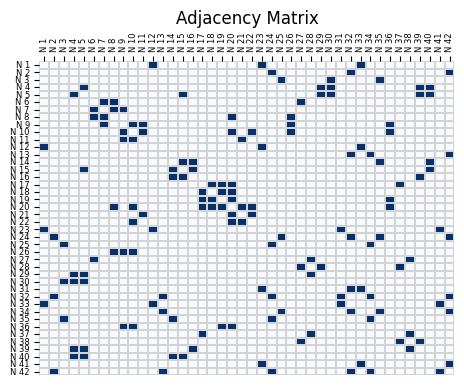

In [ ]:
# Create a dense adjacency matrix from a sparse edge index
adjacency_matrix = torch.sparse_coo_tensor(
    indices=data.edge_index,
    values=torch.ones(data.edge_index.size(1)),  # Set edge weights to 1
    size=(data.num_nodes, data.num_nodes)  # Number of nodes
)

# Convert sparse COO tensor to dense adjacency matrix
dense_adj_matrix = adjacency_matrix.to_dense()
node_labels = [f'N {i+1}' for i in range(data.num_nodes)]
# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(5, 4))
plot = sns.heatmap(dense_adj_matrix, annot=False, cmap="Blues",
            xticklabels=node_labels,
            yticklabels=node_labels,
            cbar=False, linewidths=0.2, linecolor='lightgray')

# Move x-axis labels to the top and adjust layout
plt.gca().xaxis.tick_top()
plt.setp(plot.get_xticklabels(), rotation=90)
# Set font size for x and y tick labels
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=6)
plt.tight_layout(pad=2)

plt.title("Adjacency Matrix")
plt.show()

In [ ]:
# class distribution in our dataset
enzymes = 0
non_enzymes = 0

for data in dataset:
  if data.y.item() == 1:
    enzymes += 1
  else:
    non_enzymes += 1

print(f"Number of enzymes: {enzymes}")
print(f"Number of non-enzymes: {non_enzymes}")


Number of enzymes: 450
Number of non-enzymes: 663


In [ ]:
# checking proteins with SSE of turns in proteins
indices = []
for i in range(len(dataset)):
  data = dataset[i]
  for j in range(data.x.shape[0]):
    if torch.all(data.x[j] == torch.tensor([0, 0, 1])):
      indices.append(i)
      break
print(len(indices))
print(indices)


88
[25, 36, 42, 123, 125, 168, 170, 232, 240, 305, 311, 313, 321, 343, 351, 353, 354, 410, 415, 419, 420, 424, 431, 433, 446, 453, 454, 507, 523, 537, 547, 554, 555, 563, 570, 581, 583, 587, 614, 615, 617, 621, 628, 639, 641, 642, 643, 653, 655, 656, 685, 727, 745, 750, 753, 755, 756, 765, 799, 831, 861, 885, 934, 936, 957, 969, 973, 980, 1018, 1029, 1030, 1041, 1050, 1057, 1061, 1063, 1066, 1072, 1074, 1076, 1080, 1085, 1089, 1092, 1098, 1109, 1110, 1112]


In [ ]:
data = dataset[523]
data

Data(edge_index=[2, 72], x=[21, 3], y=[1])

In [ ]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

# Compute a fixed layout
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

node_colors = ['tab:red' if f[0] > 0 else 'tab:blue' if f[1] > 0 else 'orange' for f in data.x]
pred_node_colors = ['tab:green' if p > 0 else 'tab:gray' for p in data.y]


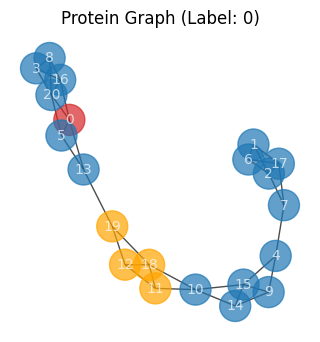

In [ ]:
# Draw the graph
plt.figure(figsize=(3, 3))
nx.draw(G, pos=pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color="white", alpha=0.7,)
plt.title(f"Protein Graph (Label: {data.y.item()})")
plt.show()

## Data Spliting and Batching

Proper data splitting is crucial for developing robust machine learning models, particularly when dealing with imbalanced datasets such as the PROTEINS dataset. The dataset contains 1,113 protein samples, with 450 labeled as enzymes and 663 labeled as non-enzymes. Two sampling methods were explored to split the imbalanced dataset:


1.   Random Sampling
2.   Stratified Sampling

**Random Sampling**

Random sampling involves assigning data points randomly to the training, validation, and test sets. This method is straightforward and effective for large, balanced datasets. However, in the case of smaller or imbalanced datasets, it can result in uneven class distribution across splits, leading to non-representative subsets.


>**Random Sampling** | Total Samples |Enzymes| Non-Enzymes
> -------------------|------------------|-----------|---------
Training       | 779 |321 | 458
Validation       | 166 | 65| 101
Test       | 168 | 64 | 104

**Stratified Sampling**

Stratified sampling ensures that the proportion of samples for each class is maintained across the training, validation, and test sets, reflecting the overall class distribution in the dataset. This method helps reduce bias in model evaluation, making it particularly useful for imbalanced datasets. Although stratified sampling is more complex to implement, it ensures that class proportions are preserved across all splits, leading to more balanced datasets. However, it may not capture other important dataset characteristics beyond class distribution.



> **Stratified  Sampling** | Total Samples |Enzymes| Non-Enzymes
>-------------------|------------------|-----------|---------
Training       | 779 |315 | 464
Validation       | 167 | 67| 100
Test       | 167 | 68 | 99




Random sampling resulted in greater variance in the enzyme vs. non-enzyme distribution across the splits. For example, the test set exhibited a larger imbalance, with 64 enzymes and 104 non-enzymes. In contrast, stratified sampling effectively preserved the original class ratio across the training, validation, and test sets. The enzyme and non-enzyme counts were more balanced, reducing differences across the sets.

Given the advantages of stratified sampling in preserving class balance, this method was selected for data splitting in the project to ensure consistent and representative subsets for model training, validation, and testing.

In [ ]:
def check_class_distribution(dataset):
  # Count the number of enzymes and non-enzymes in the dataset
  enzymes = sum(data.y.item() == 1 for data in dataset)
  non_enzymes = len(dataset) - enzymes
  return enzymes, non_enzymes

In [ ]:
# dataset = dataset.shuffle()
num_training = int(len(dataset) * 0.7)
num_val = int(len(dataset) * 0.15)
num_test = len(dataset) - (num_training + num_val)
# Split the dataset
training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test], generator=torch.Generator().manual_seed(42))

# Get class distribution for each set of the random split data
train_enzymes, train_non_enzymes = check_class_distribution(training_set)
val_enzymes, val_non_enzymes = check_class_distribution(validation_set)
test_enzymes, test_non_enzymes = check_class_distribution(test_set)

print(f"Training set Total: {len(training_set)} - Enzymes: {train_enzymes}, Non-Enzymes: {train_non_enzymes}")
print(f"Validation set Total: {len(validation_set)} - Enzymes: {val_enzymes}, Non-Enzymes: {val_non_enzymes}")
print(f"Test set Total: {len(test_set)} - Enzymes: {test_enzymes}, Non-Enzymes: {test_non_enzymes}")

Training set Total: 779 - Enzymes: 321, Non-Enzymes: 458
Validation set Total: 166 - Enzymes: 65, Non-Enzymes: 101
Test set Total: 168 - Enzymes: 64, Non-Enzymes: 104


In [ ]:
# split using stratified sampling method
from sklearn.model_selection import train_test_split

labels = [data.y for data in dataset]

# Stratified split into train and temp (for validation + test)
train_idx, temp_idx = train_test_split(range(len(labels)),
                                       test_size=0.3,
                                       stratify=labels)

# Further stratified split into validation and test
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx])

# Create train, val, test sets
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

In [ ]:
train_enzymes, train_non_enzymes = check_class_distribution(train_data)
val_enzymes, val_non_enzymes = check_class_distribution(val_data)
test_enzymes, test_non_enzymes = check_class_distribution(test_data)

print(f"Training set Total: {len(train_data)} - Enzymes: {train_enzymes}, Non-Enzymes: {train_non_enzymes}")
print(f"Validation set Total: {len(val_data)} - Enzymes: {val_enzymes}, Non-Enzymes: {val_non_enzymes}")
print(f"Test set Total: {len(test_data)} - Enzymes: {test_enzymes}, Non-Enzymes: {test_non_enzymes}")

Training set Total: 779 - Enzymes: 315, Non-Enzymes: 464
Validation set Total: 167 - Enzymes: 68, Non-Enzymes: 99
Test set Total: 167 - Enzymes: 67, Non-Enzymes: 100


## Mini-Batching
After splitting the data, batching is essential for efficient training. It enables:

* Parallel processing of multiple samples
* Memory-efficient training on large datasets
* Improved generalization through noisier gradient estimates

In PyTorch Geometric, batching is achieved by stacking adjacency matrices diagonally to form a large graph with isolated subgraphs, while node and target features are concatenated. This is handled by the torch_geometric.data.DataLoader class.

In [ ]:
# Creating DataLoader for training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
#testing the datalaoder
first_batch = next(iter(train_loader))
# Get the node indices corresponding to the first protein in the first batch of train loader
graph_index = 0
protein_node_indices = (first_batch.batch == graph_index).nonzero(as_tuple=True)[0]
protein_x = first_batch.x[protein_node_indices]  # Node features for the first protein
protein_edge_index = first_batch.edge_index[:, (first_batch.batch[first_batch.edge_index[0]] == graph_index)]  # Edges for the first protein
protein_label = first_batch.y[graph_index]  # Label for the first protein
# Print the extracted graph information
print("Node features (x) for first protein graph:")
print(protein_x)

print("\nEdge index for first protein graph:")
print(protein_edge_index)

print("\nLabel (y) for first protein graph:")
print(protein_label)

Node features (x) for first protein graph:
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

Edge index for first protein graph:
tensor([[ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  4,  5,
          5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,  9,
          9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11],
        [ 2,  5,  6,  7, 10, 11,  0,  4,  5,  6,  4,  5,  6,  2,  3,  5,  6,  0,
          2,  3,  4,  6,  0,  2,  3,  4,  5,  1,  9, 10, 11,  9, 10, 11,  7,  8,
         10, 11,  1,  7,  8,  9, 11,  1,  7,  8,  9, 10]])

Label (y) for first protein graph:
tensor(1)


# GNN Model Training

Reference: [Pytorch graph classicification tutorial  ](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=G-DwBYkquRUN)

 Training a GNN for graph classification usually follows a simple steps:

1. Node Embedding: Multiple rounds of message passing
2. Graph Embedding: Aggregation of node embeddings (readout layer)
3. Classification: Final classifier trained on the graph embedding

## Message Passing

## Aggregation

## Classification

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=20, delta=0):
        """
        Arguments:
        patience: Number of epochs to wait after no improvement.
        delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_f1 = 0

    def __call__(self, val_f1, model, optimizer, epoch, save_path='checkpoint.pth'):
        score = val_f1

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model, optimizer, epoch, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model, optimizer, epoch, save_path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, optimizer, epoch, save_path):
        """Saves model when validation F1 score improves."""
        print(f'Validation F1 score improved to {val_f1:.4f}, saving model...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, save_path)


In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Training loop
model = GCN(hidden_channels=64).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []  # To store F1 scores for training
val_f1_scores = []  # To store F1 scores for validation


# Variables to save the best model
best_val_f1 = 0  # Track best validation F1 score
best_model_path = 'best_gnn_model_f1.pth'  # Path to save the best model

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and labels for F1 score calculation (for training F1)
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(data.y.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Calculate training F1 score
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    train_f1_scores.append(train_f1)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            val_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

            # Collect predictions and labels for F1 score calculation
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(data.y.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculate validation F1 score
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    val_f1_scores.append(val_f1)

    # Print training and validation results
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    # Early stopping
    early_stopping(val_f1, model, optimizer, epoch, save_path='best_model_f1.pth')
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training is done, load the best model based on F1 score
checkpoint = torch.load('best_model_f1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Loaded the best model from epoch {checkpoint['epoch']+1} with validation F1 score {checkpoint['val_f1']:.4f}")

# Testing (after training is complete)
model.eval()
test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        test_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

        # Collect predictions and labels for F1 score calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct / total
test_f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted F1 score for test set

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


Epoch [1/100], Train Loss: 0.6861, Train Acc: 0.5571, Train F1: 0.5286, Val Loss: 0.6691, Val Acc: 0.5928, Val F1: 0.4413
Validation F1 score improved to 0.4413, saving model...
Epoch [2/100], Train Loss: 0.6744, Train Acc: 0.5956, Train F1: 0.4447, Val Loss: 0.6666, Val Acc: 0.5928, Val F1: 0.4413
Epoch [3/100], Train Loss: 0.6691, Train Acc: 0.5969, Train F1: 0.4521, Val Loss: 0.6627, Val Acc: 0.5928, Val F1: 0.4413
Epoch [4/100], Train Loss: 0.6587, Train Acc: 0.6059, Train F1: 0.4857, Val Loss: 0.6585, Val Acc: 0.6228, Val F1: 0.5055
Validation F1 score improved to 0.5055, saving model...
Epoch [5/100], Train Loss: 0.6607, Train Acc: 0.6175, Train F1: 0.5391, Val Loss: 0.6566, Val Acc: 0.6228, Val F1: 0.5692
Validation F1 score improved to 0.5692, saving model...
Epoch [6/100], Train Loss: 0.6454, Train Acc: 0.6354, Train F1: 0.5737, Val Loss: 0.6532, Val Acc: 0.6587, Val F1: 0.6342
Validation F1 score improved to 0.6342, saving model...
Epoch [7/100], Train Loss: 0.6417, Train Acc

<ipython-input-30-83ba5c509408>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_f1.pth')


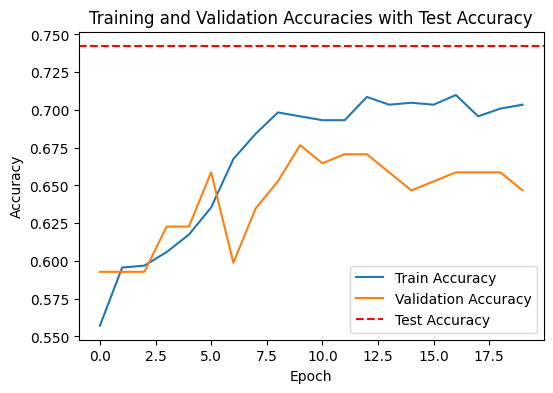

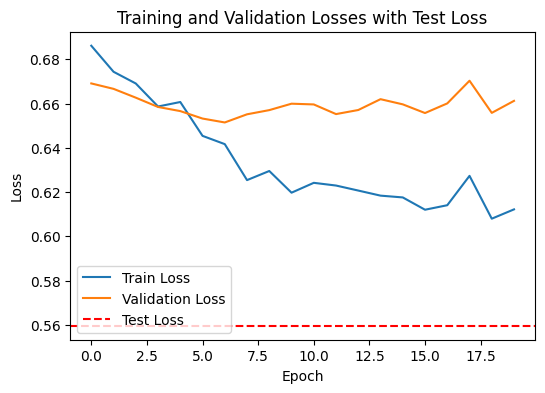

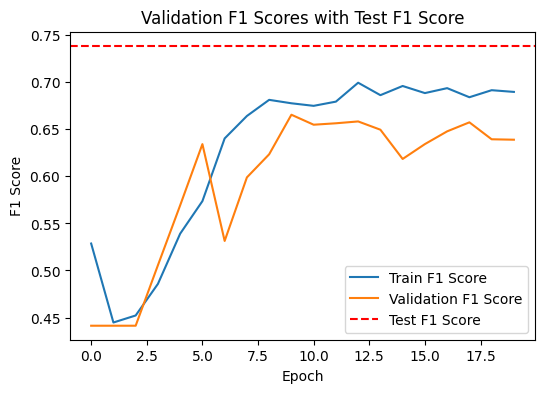

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plot test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies with Test Accuracy')
plt.legend()
plt.show()

# Plot the training and validation losses
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Plot test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses with Test Loss')
plt.legend()
plt.show()

# Plot validation F1 scores
plt.figure(figsize=(6, 4))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')  # Plot test F1 score as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Scores with Test F1 Score')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Enzyme', 'Enzyme'],
            yticklabels=['Non-Enzyme', 'Enzyme'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




---



---



Reference: https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial9/RecGNN_tutorial.ipynb

In [ ]:
from torch.nn import Parameter as Param
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import global_mean_pool

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, out_dim):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential()
        dims = [input_dim] + hid_dims + [out_dim]
        for i in range(len(dims)-1):
            self.mlp.add_module('lay_{}'.format(i),nn.Linear(in_features=dims[i], out_features=dims[i+1]))
            if i+2 < len(dims):
                self.mlp.add_module('act_{}'.format(i), nn.Tanh())
    def reset_parameters(self):
        for i, l in enumerate(self.mlp):
            if type(l) == nn.Linear:
                nn.init.xavier_normal_(l.weight)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
class GNNM(MessagePassing):
    def __init__(self, in_channels, out_channels, features_dim, hid_dims, num_layers=50, eps=1e-3, aggr='add', bias=True, **kwargs):
        super(GNNM, self).__init__(aggr=aggr, **kwargs)

        self.eps = eps
        self.num_layers = num_layers

        # MLP for transition between message-passing layers
        self.transition = MLP(features_dim, hid_dims, features_dim)

        # MLP for readout after pooling (graph-level embedding)
        self.readout = MLP(features_dim, hid_dims, out_channels)

        self.reset_parameters()
        print(self.transition)
        print(self.readout)

    def reset_parameters(self):
        self.transition.reset_parameters()
        self.readout.reset_parameters()

    def forward(self, data):
        # Graph input: batch of graphs
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for _ in range(self.num_layers):
            x = self.propagate(edge_index, x=x)  # Message passing
            x = self.transition(x)  # Apply MLP for transition

        # Global pooling: aggregate node embeddings into graph-level embeddings
        graph_embedding = global_mean_pool(x, batch)  # Batch-wise mean pooling of node embeddings

        # Final MLP for graph classification
        out = self.readout(graph_embedding)

        return F.log_softmax(out, dim=-1)  # Return log-softmax of graph-level prediction

    def message(self, x_j):
        return x_j  # Simple message passing, no edge features used in this case

    def __repr__(self):
        return '{}(in_channels={}, out_channels={}, num_layers={})'.format(self.__class__.__name__, self.in_channels, self.out_channels, self.num_layers)


In [ ]:
# Define the model
model = GNNM(
    in_channels=dataset.num_features,     # Number of input features per node
    out_channels=dataset.num_classes,     # Number of graph-level classes (2 for binary classification, etc.)
    features_dim=dataset.num_features,    # feature size for each node
    hid_dims=[64, 64],                    # Hidden dimensions of MLPs
    num_layers=3,                         # Number of message-passing layers
    eps=0.01                              # Convergence threshold for node state updates (optional)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate over batches of graphs
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Model's graph-level predictions
        loss = loss_fn(out, data.y)  # Compare with true graph-level labels
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate over batches of graphs
        data = data.to(device)
        out = model(data)  # Graph-level predictions
        pred = out.argmax(dim=1)  # Get predicted class
        correct += (pred == data.y).sum().item()  # Compare with true labels
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 51):  # 50 epochs
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

MLP(
  (mlp): Sequential(
    (lay_0): Linear(in_features=3, out_features=64, bias=True)
    (act_0): Tanh()
    (lay_1): Linear(in_features=64, out_features=64, bias=True)
    (act_1): Tanh()
    (lay_2): Linear(in_features=64, out_features=3, bias=True)
  )
)
MLP(
  (mlp): Sequential(
    (lay_0): Linear(in_features=3, out_features=64, bias=True)
    (act_0): Tanh()
    (lay_1): Linear(in_features=64, out_features=64, bias=True)
    (act_1): Tanh()
    (lay_2): Linear(in_features=64, out_features=2, bias=True)
  )
)
Epoch: 001, Train Loss: 0.6807, Train Acc: 0.6303, Test Acc: 0.6287
Epoch: 002, Train Loss: 0.6639, Train Acc: 0.6431, Test Acc: 0.6467
Epoch: 003, Train Loss: 0.6445, Train Acc: 0.6727, Test Acc: 0.7006
Epoch: 004, Train Loss: 0.5983, Train Acc: 0.7291, Test Acc: 0.7545
Epoch: 005, Train Loss: 0.5767, Train Acc: 0.7291, Test Acc: 0.7605
Epoch: 006, Train Loss: 0.5644, Train Acc: 0.7279, Test Acc: 0.7365
Epoch: 007, Train Loss: 0.5639, Train Acc: 0.7356, Test Acc: 0.7365




---



---



In [ ]:
class ClassicalIterativeGNN(nn.Module):
    def __init__(self, num_node_features, hidden_size, num_classes, num_iterations=5):
        super(ClassicalIterativeGNN, self).__init__()
        self.num_iterations = num_iterations


        # State update function
        self.state_update = nn.Sequential(
            nn.Linear(num_node_features + hidden_size, hidden_size),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Output function
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        num_nodes = x.size(0)

        # Initialize node states (h) with zeros, shape: (num_nodes, hidden_size)
        h = torch.zeros(num_nodes, self.state_update[0].out_features).to(x.device)

        # Iterative state update
        for _ in range(self.num_iterations):
            # Aggregate neighbor states
            neighbor_states = h[edge_index[1]]  # Neighbor states

            # If edge attributes are present, concatenate them with neighbor states
            if edge_attr is not None:
                edge_states = torch.cat([neighbor_states, edge_attr], dim=1)
            else:
                edge_states = neighbor_states  # If no edge features, only use neighbor states

            # Aggregate states from neighbors (message passing)
            aggregated = torch_geometric.utils.scatter(edge_states, edge_index[0], dim=0, dim_size=num_nodes, reduce='mean')

            # Update node states by concatenating original node features (x) with aggregated neighbor information and hidden state (h)
            node_inputs = torch.cat([x, aggregated], dim=1)  # Concatenate x (node features) and aggregated messages
            h = self.state_update(node_inputs)

        # Global mean pooling to get graph-level representation
        graph_embedding = torch_geometric.nn.global_mean_pool(h, batch)

        # Compute the output for classification
        out = self.output(graph_embedding)
        return F.log_softmax(out, dim=1)

# Model Traing and Experimentation

In [ ]:
def run_experiment(hidden_size, num_iterations, lr, num_epochs):
    # Create DataLoader
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = ClassicalIterativeGNN(num_node_features=dataset.num_node_features,
                                  hidden_size=hidden_size,
                                  num_classes=dataset.num_classes,
                                  num_iterations=num_iterations)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define criterion
    criterion = nn.NLLLoss()

    # Initialize lists to store metrics
    train_losses = []
    test_accuracies = []
    f1_scores = []

    # Initialize TensorBoard writer
    writer = SummaryWriter(f'runs/experiment_h{hidden_size}_i{num_iterations}_lr{lr}')

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        avg_loss = total_loss / len(loader.dataset)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        predictions = []
        true_labels = []
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            predictions.extend(pred.tolist())
            true_labels.extend(data.y.tolist())

        accuracy = correct / len(loader.dataset)
        f1 = f1_score(true_labels, predictions, average='weighted')

        test_accuracies.append(accuracy)
        f1_scores.append(f1)

        print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/test', accuracy, epoch)
        writer.add_scalar('F1 Score', f1, epoch)

    writer.close()

    return train_losses, test_accuracies, f1_scores

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


In [ ]:
# Function to run multiple experiments and plot results
def compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs):
    results = {}
    for hidden_size in hidden_sizes:
        for num_iterations in num_iterations_list:
            for lr in learning_rates:
                key = f'h{hidden_size}_i{num_iterations}_lr{lr}'
                print(f'Running experiment: {key}')
                train_losses, test_accuracies, f1_scores = run_experiment(hidden_size, num_iterations, lr, num_epochs)
                results[key] = {
                    'train_losses': train_losses,
                    'test_accuracies': test_accuracies,
                    'f1_scores': f1_scores
                }

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for key, data in results.items():
        ax1.plot(data['train_losses'], label=key)
        ax2.plot(data['test_accuracies'], label=key)
        ax3.plot(data['f1_scores'], label=key)

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png')
    plt.show()

    # Save results to a JSON file
    with open('experiment_results.json', 'w') as f:
        json.dump(results, f)


In [ ]:
# Run experiments
# Set 1
hidden_sizes = [64, 128, 256]
num_iterations_list = [5, 10]
learning_rates = [0.01, 0.001]
num_epochs = 100

compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs)

In [ ]:
hidden_sizes = [64, 128, 256]
num_iterations_list = [2,3,4]
learning_rates = [0.01, 0.001]
num_epochs = 100

compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs)

In [ ]:
!zip -r /content/runs.zip /content/runs
from google.colab import files
files.download("/content/runs.zip")


In [ ]:
!zip -r /content/PROTEINS.zip /content/PROTEINS
from google.colab import files
files.download("/content/PROTEINS.zip")


In [ ]:
import plotly.graph_objects as go
# To load and plot results later:
with open('experiment_results.json', 'r') as f:
    loaded_results = json.load(f)
# Then use the plotting code from compare_hyperparameters to visualize loaded_results

epochs = list(range(100))
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['train_losses'], mode='lines', name=f'{label} - Train Loss'))

# Customize layout
fig.update_layout(
    title="Training Loss",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['test_accuracies'], mode='lines', name=f'{label} - Test Accuracy'))

# Customize layout
fig.update_layout(
    title="Test Accuracies",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['f1_scores'], mode='lines', name=f'{label} - F1 Score'))

# Customize layout
fig.update_layout(
    title="F1 Scores",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
import json

def find_best_hyperparameters(results_file='experiment_results.json'):
    # Load the results from the JSON file
    with open(results_file, 'r') as f:
        results = json.load(f)

    # Initialize variables to store the best results
    best_accuracy = 0
    best_f1_score = 0
    best_accuracy_params = None
    best_f1_params = None

    # Iterate over the results to find the best accuracy and F1 score
    for key, data in results.items():
        # Get the highest accuracy and F1 score from each experiment
        max_accuracy = max(data['test_accuracies'])
        max_f1_score = max(data['f1_scores'])

        # Check if it's the best accuracy so far
        if max_accuracy > best_accuracy:
            best_accuracy = max_accuracy
            best_accuracy_params = key

        # Check if it's the best F1 score so far
        if max_f1_score > best_f1_score:
            best_f1_score = max_f1_score
            best_f1_params = key

    # Print the best results
    print(f"Best Accuracy: {best_accuracy:.4f} with hyperparameters: {best_accuracy_params}")
    print(f"Best F1 Score: {best_f1_score:.4f} with hyperparameters: {best_f1_params}")

# After the experiments are done, call the function to find the best hyperparameters
find_best_hyperparameters()

Best Accuracy: 0.7772 with hyperparameters: h256_i5_lr0.001
Best F1 Score: 0.7772 with hyperparameters: h256_i5_lr0.001




---



# Bench Mark Setup Code

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load the dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Normalize node features
mean = dataset.data.x.mean(dim=0, keepdim=True)
std = dataset.data.x.std(dim=0, keepdim=True)
dataset.data.x = (dataset.data.x - mean) / std

# Define the GNN model (using GCN as an example)
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2)  # 2 classes for binary classification

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, loader, optimizer, device):
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())
    return accuracy_score(labels, predictions), f1_score(labels, predictions, average='macro')

# Set up cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare data for cross-validation
dataset_indices = list(range(len(dataset)))
dataset_labels = [data.y.item() for data in dataset]

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
hidden_channels = 64
learning_rate = 0.01
num_epochs = 200
batch_size = 32

# Lists to store results
accuracies = []
f1_scores = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, dataset_labels)):
    print(f"Fold {fold + 1}/{n_splits}")

    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = GCN(num_node_features=dataset.num_node_features, hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_acc = 0
    patience = 50
    counter = 0

    for epoch in range(num_epochs):
        train(model, train_loader, optimizer, device)
        val_acc, val_f1 = evaluate(model, val_loader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Final evaluation
    final_acc, final_f1 = evaluate(model, val_loader, device)
    accuracies.append(final_acc)
    f1_scores.append(final_f1)
    print(f"Fold {fold + 1} - Accuracy: {final_acc:.4f}, F1-score: {final_f1:.4f}")

# Print final results
print(f"\nFinal Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Mean F1-score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")